#import libraries

In [4]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#import yelp review data set and save data into csv file

In [5]:
# Once you excute this code sucessfully no need to run it again
with open('yelp_academic_dataset_review.json', 'r', encoding='utf-8') as json_type_file:
    data = [json.loads(line) for line in json_type_file]

In [6]:
# count length of the array
number_of_rows = len(data)
number_of_rows

6990280

In [7]:
# add data into a dataframe
df = pd.DataFrame(data)

In [8]:
df.head(10)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
8,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1,1,0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33
9,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06


In [9]:
# save it in a csv file
df.to_csv('yelp_reviews.csv', index=False)

In [10]:
# import csv file
df1 = pd.read_csv('yelp_reviews.csv')

In [11]:
df1.shape

(6990280, 9)

#data cleaning

In [12]:
df1.head(6)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31


In [13]:
df2 = df1.drop(['review_id','user_id','business_id','useful','funny','cool','date'] ,axis=1 , inplace=False)

In [14]:
df2.head(6)

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...
5,1.0,I am a long term frequent customer of this est...


In [15]:
df2.isnull().sum()

stars    0
text     0
dtype: int64

In [16]:
df2.duplicated().sum()

14858

In [17]:
df3 = df2.drop_duplicates(inplace=False)

In [18]:
df3.duplicated().sum()

0

In [19]:
df3.head(6)

,stars,text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...
5,1.0,I am a long term frequent customer of this est...


<Axes: title={'center': 'Review Stars'}, xlabel='stars'>

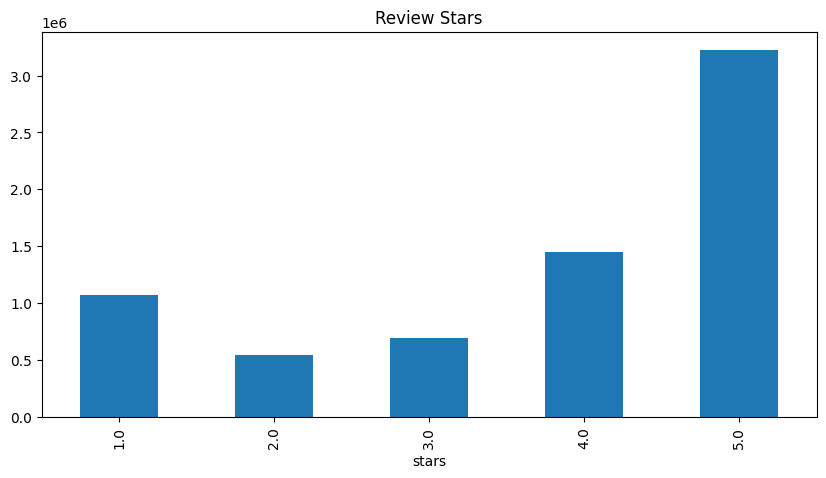

In [20]:
df3['stars'].value_counts().sort_index().plot(kind='bar', title="Review Stars", figsize=(10,5))

In [21]:
# 0 - negative
# 1 - neutral
# 2 - positive

# Function to convert score to sentiment
def sentiment(rating):
    
    rating = int(rating)
    # Convert to class
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2

# Apply to the dataset 
df3['sentiment'] = df3['stars'].apply(sentiment)

C:\Users\Roshen Hasangha\AppData\Local\Temp\ipykernel_17304\4007003634.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['sentiment'] = df3['stars'].apply(sentiment)


In [22]:
df3.head(10)

,stars,text,sentiment
0,3.0,"If you decide to eat here, just be aware it is...",1
1,5.0,I've taken a lot of spin classes over the year...,2
2,3.0,Family diner. Had the buffet. Eclectic assortm...,1
3,5.0,"Wow! Yummy, different, delicious. Our favo...",2
4,4.0,Cute interior and owner (?) gave us tour of up...,2
5,1.0,I am a long term frequent customer of this est...,0
6,5.0,Loved this tour! I grabbed a groupon and the p...,2
7,5.0,Amazingly amazing wings and homemade bleu chee...,2
8,3.0,This easter instead of going to Lopez Lake we ...,1
9,3.0,Had a party of 6 here for hibachi. Our waitres...,1


In [23]:
df3['sentiment'].value_counts().sort_index()

sentiment
0    1609825
1     691016
2    4674581
Name: count, dtype: int64

In [24]:
df4=df3.iloc[:10000]
df4

,stars,text,sentiment
0,3.0,"If you decide to eat here, just be aware it is...",1
1,5.0,I've taken a lot of spin classes over the year...,2
2,3.0,Family diner. Had the buffet. Eclectic assortm...,1
3,5.0,"Wow! Yummy, different, delicious. Our favo...",2
4,4.0,Cute interior and owner (?) gave us tour of up...,2
...,...,...,...
9995,5.0,Excellent food and service. The place is funct...,2
9996,5.0,Just about to get tucked into a meatloaf that ...,2
9997,5.0,Outstanding customer service! And my car is dr...,2
9998,5.0,I and my husband went here for Dinner one day ...,2


SMOTE ANALYSIS


In [25]:
features_for_smote = ['stars', 'text', 'sentiment']
df_for_smote = df4[features_for_smote].dropna()

In [26]:
X = df_for_smote[['stars', 'text']]
y = df_for_smote['sentiment']

In [27]:
vectorizer = CountVectorizer()
X_text_vectorized = vectorizer.fit_transform(X['text'])

In [28]:
# Combine numerical features with sparse text vectorized features
X_combined = pd.concat([X[['stars']], pd.DataFrame(X_text_vectorized.toarray())], axis=1)

# Convert feature names to strings
X_combined.columns = X_combined.columns.astype(str)

In [29]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_combined, y)

# Convert feature names to strings in the resampled data
X_resampled.columns = X_resampled.columns.astype(str)

In [30]:
y_resampled_counts = pd.Series(y_resampled).value_counts()

# Create a DataFrame for better visualization
sentiment_distribution_df = pd.DataFrame({'Sentiment': y_resampled_counts.index, 'Count': y_resampled_counts.values})

# Display the sentiment distribution DataFrame
print(sentiment_distribution_df)

   Sentiment  Count
0          1   7019
1          2   7019
2          0   7019


BERT

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch
from tqdm import tqdm

In [32]:
df5=df3.iloc[:2000]
df5

,stars,text,sentiment
0,3.0,"If you decide to eat here, just be aware it is...",1
1,5.0,I've taken a lot of spin classes over the year...,2
2,3.0,Family diner. Had the buffet. Eclectic assortm...,1
3,5.0,"Wow! Yummy, different, delicious. Our favo...",2
4,4.0,Cute interior and owner (?) gave us tour of up...,2
...,...,...,...
1995,4.0,"I eat at Sukho Thai quite a bit, and I don't r...",2
1996,5.0,"When you dine at Muriel's, check to see if the...",2
1997,5.0,Had a wonderful lunch of fried green tomatoes ...,2
1998,3.0,I like to make a stop at this Walmart since it...,1


In [46]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_data(data, tokenizer, max_length=128):
    tokenized = tokenizer(data['text'].tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    labels = torch.tensor(data['sentiment'].tolist())
    return tokenized, labels

In [60]:
train_data, test_data = train_test_split(df5, test_size=0.2, random_state=42)


In [61]:
# Tokenize training and testing data
train_encodings, train_labels = tokenize_data(train_data, tokenizer)
test_encodings, test_labels = tokenize_data(test_data, tokenizer)

In [62]:
# Model definition
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df5['sentiment'].unique()))
optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Roshen Hasangha\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Convert data to PyTorch tensors
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

In [ ]:
# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [63]:
epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {avg_loss:.4f}')


Epoch 1/3: 100%|██████████| 200/200 [45:31<00:00, 13.66s/it]   


Epoch 1/3, Average Loss: 0.6387


Epoch 2/3: 100%|██████████| 200/200 [16:49<00:00,  5.05s/it]


Epoch 2/3, Average Loss: 0.3892


Epoch 3/3: 100%|██████████| 200/200 [19:50<00:00,  5.95s/it]

Epoch 3/3, Average Loss: 0.2517


In [64]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluation loop
model.eval()
total_correct = 0
total_samples = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Evaluating'):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)

        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        
         # Append true labels and predicted labels
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predictions.cpu().numpy())

accuracy = total_correct / total_samples
print(f'Test Accuracy: {accuracy * 100:.2f}%')

class_report = classification_report(all_labels, all_preds)
print(f'Classification Report:\n{class_report}')

Evaluating: 100%|██████████| 50/50 [01:09<00:00,  1.38s/it]

Test Accuracy: 82.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75        66
           1       0.53      0.29      0.38        58
           2       0.86      0.97      0.91       276

    accuracy                           0.82       400
   macro avg       0.73      0.65      0.68       400
weighted avg       0.80      0.82      0.81       400



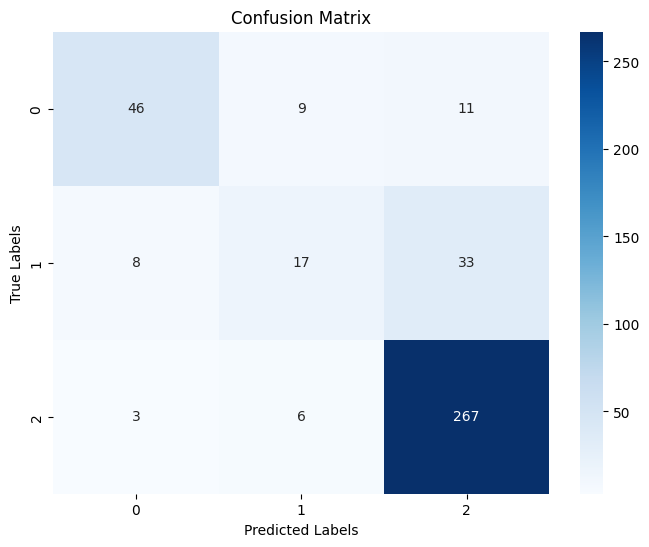

In [65]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

conf_matrix = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
